# Math 432 — NumPy, Dot Products, and Linear Regression

**Learning goals**
1. Get comfortable with vectors and matrices in NumPy.
2. Understand the dot product algebraically and geometrically (angles, projections).
3. Fit a linear model by viewing regression as an **orthogonal projection**—no statistics jargon.

> **How to use this notebook:** Run cells top to bottom. If something errors, use *Kernel → Restart & Run All*.

## 0. Setup
We will use only NumPy and Matplotlib.

In [2]:
# %matplotlib inline
# %pip install numpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
np.set_printoptions(suppress=True, precision=4)  # prettier printing

# Random generator for reproducibility
rng = np.random.default_rng(432)

## 1. Vectors and Matrices in NumPy
- A **vector** is a 1D array, e.g. shape `(n,)`.
- A **matrix** is a 2D array, e.g. shape `(m, n)`.
- The attribute ``.shape`` reports dimensions.
- Matrix multiplication uses the `@` operator (or `np.matmul`).

In [3]:
# Create vectors and matrices
v = np.array([2, -1, 3])             # shape (3,)
y = np.array([4, 0, 1])              # shape (3,)
A = np.array([[1, 2, 0],
              [0, -1, 3]])           # shape (2,3)
B = np.array([[2, 1, -1],
              [1, 0,  4],
              [0, 2,  2]])           # shape (3,3)

print('v:', v, ' shape =', v.shape)
print('A:', A, '\nshape =', A.shape)

v: [ 2 -1  3]  shape = (3,)
A: [[ 1  2  0]
 [ 0 -1  3]] 
shape = (2, 3)


### Basic operations
- Elementwise: `v + w`, `3*v`, `v * w` (Hadamard product; we'll almost never use this for matrices).
- Matrix–vector: `A @ v`.
- Matrix–matrix: `A @ B`.
- Transpose: `A.T`. 
- Identity: `np.eye(n)`.
- Vector length: `np.linalg.norm(v)`. 
- Solve `Bx = y` via `np.linalg.solve(B, y)`.

In [4]:
print('v + y =', v + y)
print('3*v   =', 3*v)
print('A @ v =', A @ v)           # (2x3)@(3,) -> (2,)
print('A @ B =\n', A @ B)        # (2x3)@(3x3) -> (2x3)
print('A^T =\n', A.T)
I3 = np.eye(3)
print('I3 =\n', I3)
print('||v|| =', np.linalg.norm(v))

# Solve Bx = w (B must be invertible)
x = np.linalg.solve(B, y)
print('Solution x to Bx=y:', x)
print('Check B @ x (should equal y):', B @ x)

v + y = [ 6 -1  4]
3*v   = [ 6 -3  9]
A @ v = [ 0 10]
A @ B =
 [[ 4  1  7]
 [-1  6  2]]
A^T =
 [[ 1  0]
 [ 2 -1]
 [ 0  3]]
I3 =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
||v|| = 3.7416573867739413
Solution x to Bx=y: [ 1.4   0.85 -0.35]
Check B @ x (should equal y): [4. 0. 1.]


> **Exercise 1.1**
> 1. Create a random 4x4 matrix `C = rng.normal(size=(4,4))` and a 4-vector `y = rng.normal(size=4)`.
> 2. Compute `C @ y`, `C.T`, and solve `C z = y` using `np.linalg.solve`.
> 3. Verify your solution by computing `C @ z` (should match `y` up to rounding).

In [5]:
# your work here
C = rng.normal(size=(4,4))
y = rng.normal(size=4)
CC = C @ y
CT = C.T
z = np.linalg.solve(C, y)
print('Check:', np.allclose(C @ z, y))
pass

Check: True


> **Exercise 1.2**
> 1. Define a 5x2 matrix X (e.g. the one from class).
> 2. Use `numpy` to compute $X^\top X$.
> 3. What happens if you add a third column to $X$ that's a linear combination of the first two?

In [6]:
# your work here
X = np.array([[1, 1],
              [2, 0],
              [3, 2],
              [4, 8],
              [5, 2]])
Xt = X.T
print('X^T X =\n', Xt @ X)
# Adding a third column that's a linear combination would be redundant and make X^T X singular, so we can't invert it
pass

X^T X =
 [[55 49]
 [49 73]]


### Tip: column vectors in NumPy
NumPy uses 1D arrays for vectors, shape `(n,)`. To make an explicit column vector with shape `(n,1)`, do `v[:, None]`.
This sometimes matters, e.g. when forming outer products like `v[:, None] @ w[None, :]`.

## 2. Dot Product — Algebra and Geometry
For $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$, the **dot product** is
$$\mathbf{x} \cdot \mathbf{y} = \sum_{i=1}^n x_i y_i = \mathbf{x}^\top \mathbf{y}.$$

In NumPy: `x @ y` or `np.dot(x, y)`. The dot product connects to the angle $\theta$ via
$$\mathbf{x} \cdot \mathbf{y} = \|\mathbf{x} \|\,\| \mathbf{y} \|\cos \theta,$$
so
- $\mathbf{x} \cdot \mathbf{y} = 0$ $\Leftrightarrow$ $\mathbf{x}$ and $\mathbf{y}$ are **orthogonal**.
- The **projection** of $\mathbf{y}$ onto the line through $\mathbf{x}$ is 
  $$\operatorname{proj}_{\mathbf{x}}(\mathbf{y}) = \frac{\mathbf{x}\cdot \mathbf{y}}{\mathbf{x}\cdot \mathbf{x}}\, \mathbf{x}.$$

In [7]:
x = np.array([3.0, 4.0])
y = np.array([5.0, 1.0])
dot_xy = x @ y
cos_theta = dot_xy / (np.linalg.norm(x) * np.linalg.norm(y))
theta_deg = np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))
print('x·y =', dot_xy)
print('θ (degrees) =', theta_deg)

proj_y_on_x = ((x @ y) / (x @ x)) * x
r = y - proj_y_on_x
print('proj_x(y) =', proj_y_on_x)
print('x·r (≈ 0) =', x @ r)

x·y = 19.0
θ (degrees) = 41.820169880135765
proj_x(y) = [2.28 3.04]
x·r (≈ 0) = 0.0


### Visualizing projection in 2D

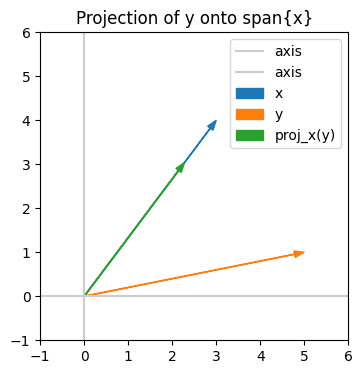

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
ax.axhline(0, color='0.8'); ax.axvline(0, color='0.8')
def arrow(v, **kw):
    ax.arrow(0, 0, v[0], v[1], head_width=0.15, length_includes_head=True, **kw)
arrow(x, color='C0', width=0.01)
arrow(y, color='C1', width=0.01)
arrow(proj_y_on_x, color='C2', width=0.01)
ax.set_aspect('equal', 'box')
ax.set_xlim(-1, 6); ax.set_ylim(-1, 6)
ax.set_title('Projection of y onto span{x}')
ax.legend(['axis', 'axis', 'x','y','proj_x(y)'])
plt.show()

> **Exercise 2.1**
> - Write a function `proj(u, v)` returning the projection of `v` onto the line spanned by `u`.
> - Pick two 3D vectors and verify orthogonality: `u @ (v - proj(u, v)) ≈ 0`.

In [9]:
# work
def proj(u, v):
    return ( (u @ v) / (u @ u) ) * u
u = np.array([1, 1, 1])
v = np.array([1, 3, -5])
print(u @ (v - proj(u, v)))
pass

0.0


## 3. Linear Regression
We collect features into a **design matrix** $X\in \mathbb{R}^{n \times d}$ and labels into $y \in \mathbb{R}^n$.
We seek coefficients $\mathbf{w} \in \mathbb{R}^d$ so that $X\mathbf{w}$ is as close as possible to $\mathbf{y}$ in the Euclidean sense:
$$\mathbf{w}^* = \argmin_{\mathbf{w}} \; \|y - X\mathbf{w}\|^2.$$
The geometric solution: the best approximation $\hat{\mathbf{y}} = X\mathbf{w}$ is the **orthogonal projection** of $\mathbf{y}$ 
onto the column space of $X$.
This orthogonality condition yields the **normal equations**
$$X^\top (y - X\mathbf{w}) = 0 \quad \Rightarrow \quad X^\top X \mathbf{w} = X^\top \mathbf{y}. $$
We will compute $\mathbf{w}$ using a numerically stable least-squares solver.

### Starter example
We finish the example from class:
$$(1,2), (2,1), (3,3), (4,2), (5,4)$$

In [10]:

# A. Data
x = np.array([1, 2, 3, 4, 5], dtype=float)
y = np.array([2, 1, 3, 2, 4], dtype=float)

# B. Design matrix
X = np.column_stack([x, np.ones_like(x)])   # stack the features alongside a column of 1s
print('Design matrix X:\n', X)

# C. Compute X^T
Xt = X.T
print('X^T:\n', Xt)

# D. Compute X^T X
XtX = Xt @ X
print('X^T X:\n', XtX)

Design matrix X:
 [[1. 1.]
 [2. 1.]
 [3. 1.]
 [4. 1.]
 [5. 1.]]
X^T:
 [[1. 2. 3. 4. 5.]
 [1. 1. 1. 1. 1.]]
X^T X:
 [[55. 15.]
 [15.  5.]]


> **Exercise.** Finish the example above by solving for the least-squares solution $\mathbf{w} = [w_1, w_2]^\top$.

In [11]:
# TODO: your work here
# find the inverse of XtX:
XtX_inv = np.linalg.inv(XtX)
print(' (X^T X)^-1:\n', XtX_inv)
w = XtX_inv @ (Xt @ y)
print('Least-squares solution w:\n', w)
print('Check: X^T(Xw) = X^Ty:\n', Xt @ (X @ w), '=?=', Xt @ y)
print('Another verify using numpy: ')
w, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
print("w =", w)
pass

 (X^T X)^-1:
 [[ 0.1 -0.3]
 [-0.3  1.1]]
Least-squares solution w:
 [0.5 0.9]
Check: X^T(Xw) = X^Ty:
 [41. 12.] =?= [41. 12.]
Another verify using numpy: 
w = [0.5 0.9]


Let's plot your least-squares solution along with the data!

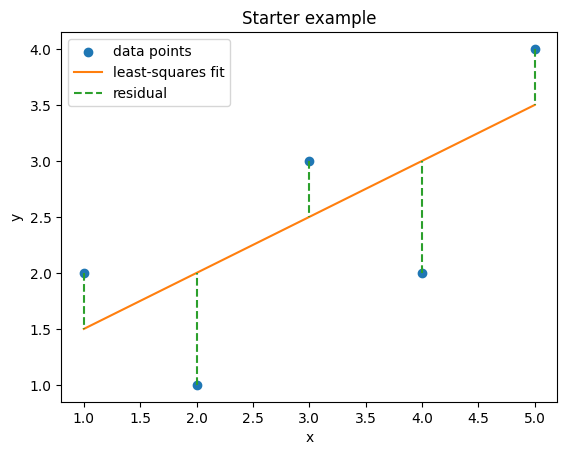

In [12]:
## for testing:
w = np.array([0.5, 1.0])   # slope=0.5, intercept=1.0
# # The shape of your w should be (2,), where w[0] is the slope and w[1] is the intercept,
# in order for this part to work.
# plot the data from the starter example and the least-squares line
# plot the five points stored in (x,y):
plt.scatter(x, y, color='C0', label='data points')
# plot the least-squares line y = w[0]*x + w[1]:
plt.plot(x, w[0]*x + w[1], color='C1', label='least-squares fit')
# add the residuals as dashed lines
for xi, yi in zip(x, y):
    plt.plot([xi, xi], [yi, w[0]*xi + w[1]], color='C2', linestyle='--', label='residual' if xi == x[0] else "")
plt.xlabel('x'); plt.ylabel('y')
plt.title('Starter example')   
plt.legend()
plt.show()

### Example: Fit a line to data (with intercept)
We generate data from a line with small noise and recover the slope/intercept.

Estimated slope    = 2.5011650601974904
Estimated intercept= -1.0352579251685097
x · r (≈ 0): 8.704148513061227e-14
1 · r (≈ 0): -5.329070518200751e-15


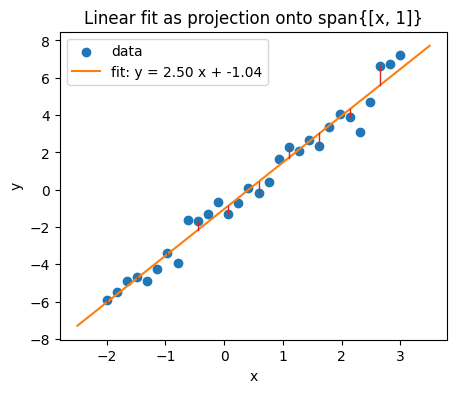

In [13]:
# Generate synthetic data: y = 2.5 x - 1.0 + noise
n = 30
x = np.linspace(-2, 3, n)
true_slope, true_intercept = 2.5, -1.0
y = true_slope * x + true_intercept + rng.normal(0, 0.6, size=n)

# Build design matrix with a column of ones for the intercept/bias
# Model: y ≈ slope*x + intercept
X = np.column_stack([x, np.ones_like(x)])

# Solve least squares without forming (X^T X)^{-1} explicitly
beta_hat, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
slope_hat, intercept_hat = beta_hat
print('Estimated slope    =', slope_hat)
print('Estimated intercept=', intercept_hat)

# Predicted values and residuals
y_hat = X @ beta_hat
r = y - y_hat

# Orthogonality of residuals to columns of X
print('x · r (≈ 0):', x @ r)
print('1 · r (≈ 0):', np.ones_like(x) @ r)

# Plot data and fitted line
xx = np.linspace(x.min()-0.5, x.max()+0.5, 200)
yy = slope_hat * xx + intercept_hat
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(x, y, color='C0', label='data')
ax.plot(xx, yy, color='C1', label=f'fit: y = {slope_hat:.2f} x + {intercept_hat:.2f}')
for i in range(0, n, max(1, n//8)):
    ax.plot([x[i], x[i]], [y_hat[i], y[i]], color='C3', lw=1)  # residual segment
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.legend()
ax.set_title('Linear fit as projection onto span{[x, 1]}')
plt.show()

**Exercise 3.1**  **Normal equations (direct solve).** Compute 
`beta_NE = np.linalg.solve(X.T @ X, X.T @ y)` (when invertible) and compare with `beta_hat` from `lstsq`.

Check `np.allclose(beta_NE, beta_hat)`. (The function `allclose` determines whether its arguments are element-wise equal to within a specified tolerance.)

In [14]:
# Your work
beta_NE = np.linalg.solve(X.T @ X, X.T @ y)
beta_hat, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
print('Match with lstsq?', np.allclose(beta_NE, beta_hat))
pass

Match with lstsq? True


**Exercise 3.2**  **Column scaling.** Let `s = 2*x`. Form `Xs = np.column_stack([s, np.ones_like(s)])`.
- Fit with `Xs`. Compare predicted values `X @ beta_hat` vs `Xs @ beta_s_hat`.
- They should match (same line), though coefficients differ due to scaling.

In [15]:
# Your work
Xs = np.column_stack([2*x, np.ones_like(x)])
beta_s_hat, *_ = np.linalg.lstsq(Xs, y, rcond=None)
print('Predictions match?', np.allclose(X @ beta_hat, Xs @ beta_s_hat))
pass

Predictions match? True


**Exercise 3.3**  **Rank deficiency (duplicate column).** Let `Xd = np.column_stack([x, x, np.ones_like(x)])`.
- Solve with `np.linalg.lstsq` and inspect the reported `rank`.
- Observe that predictions still match the 2-column model, but `rank < #columns`.

In [16]:
# Your work
Xd = np.column_stack([x, x, np.ones_like(x)])
beta_d, residuals_d, rank_d, s_d = np.linalg.lstsq(Xd, y, rcond=None)
print('rank(Xd) =', rank_d)
print('Predictions match?', np.allclose(Xd @ beta_d, X @ beta_hat))
pass

rank(Xd) = 2
Predictions match? True



### Exercise: Two‑feature least squares with a 3D visualization

We will create data from a plane
$y = a\,x_1 + b\,x_2 + c + \varepsilon$,
with small noise $\varepsilon$, then recover $(a,b,c)$ by least squares.  

**Tasks**
1. Generate $n$ points $(x_1, x_2)$ and noisy $y$ from a known plane.
2. Build $X = [\,x_1\ \ x_2\ \ 1\,]$ and compute $\mathbf{w}^*$ with `np.linalg.lstsq`.
3. Verify orthogonality: compute $X^\top r$ and its norm.
4. Make a **3D scatter** of $(x_1,x_2,y)$ and overlay the **fitted plane**.
5. (Optional) Draw a few **vertical residuals** from the plane to data points.

Try changing the noise level $\sigma$, sample size $n$, or the true coefficients and see how the fit and residuals behave.


In [27]:
# 3D plot of least squares plane
# you might first need one or both of these:
# %pip install plotly -q
# %pip install -U nbformat plotly
import plotly.graph_objects as go

# --- generate noisy observations ---
rng = np.random.default_rng(432)
n = 150     ### try changing this!
x1 = rng.uniform(-2, 3, size=n)
x2 = rng.uniform(-1, 4, size=n)
a_true, b_true, c_true = 1.5, -0.8, 0.2 ### feel free to change these!
sigma = 0.1    ### try changing this!
y_clean = a_true * x1 + b_true * x2 + c_true
y = y_clean + rng.normal(0, sigma, size=n)

X = np.column_stack([x1, x2, np.ones_like(x1)])
beta_hat, *_ = np.linalg.lstsq(X, y, rcond=None)
a_hat, b_hat, c_hat = beta_hat

# Plane grid
x1g = np.linspace(x1.min()-0.5, x1.max()+0.5, 40)
x2g = np.linspace(x2.min()-0.5, x2.max()+0.5, 40)
X1g, X2g = np.meshgrid(x1g, x2g)
Yg = a_hat * X1g + b_hat * X2g + c_hat

# 3D scatter of data
scatter = go.Scatter3d(
    x=x1, y=x2, z=y,
    mode='markers',
    marker=dict(size=4, color='royalblue', opacity=0.9),
    name='data'
)

# Fitted plane
surface = go.Surface(
    x=x1g, y=x2g, z=Yg,
    colorscale='Viridis', opacity=0.6, showscale=False,
    name='fitted plane'
)

# A few vertical residuals
residual_traces = []
step = max(1, n // 12)
for i in range(0, n, step):
    yhat_i = a_hat * x1[i] + b_hat * x2[i] + c_hat
    residual_traces.append(
        go.Scatter3d(
            x=[x1[i], x1[i]],
            y=[x2[i], x2[i]],
            z=[yhat_i, y[i]],
            mode='lines',
            line=dict(color='crimson', width=3),
            showlegend=(i == 0),
            name='residual (vertical)'
        )
    )

fig = go.Figure(data=[scatter, surface, *residual_traces])
fig.update_layout(
    title='Least squares plane: $y \\approx a\\,x_1 + b\\,x_2 + c$',
    scene=dict(
        xaxis_title='x1', yaxis_title='x2', zaxis_title='y',
        aspectmode='cube'
    ),
    margin=dict(l=0, r=0, t=40, b=0)
)
fig.show()
print(f'True plane:     y = {a_true:.2f} x1 + {b_true:.2f} x2 + {c_true:.2f}')
print(f'Fitted plane:   y = {a_hat:.2f} x1 + {b_hat:.2f} x2 + {c_hat:.2f}')

True plane:     y = 1.50 x1 + -0.80 x2 + 0.20
Fitted plane:   y = 1.50 x1 + -0.81 x2 + 0.21


If you were having trouble installing plotly, you can try this matplotlib version.

Note: you may need to restart the kernel to use updated packages.
Estimated coefficients:
  a (x1) ≈ 1.4935   (true: 1.5)
  b (x2) ≈ -0.8160   (true: -0.8)
  c      ≈ 0.2255   (true: 0.2)

Orthogonality check:
  ||X^T r||_2 = 3.7060274182462047e-13
  Components of X^T r: [-0. -0. -0.]


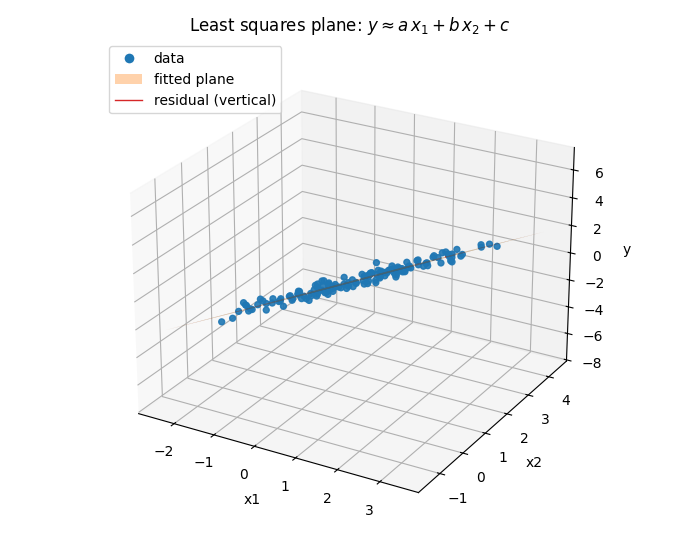

In [18]:

%pip install -q ipympl
%matplotlib widget

# 1) Generate synthetic two-feature data from a plane with small noise
rng = np.random.default_rng(432)  # reproducible
n = 150
x1 = rng.uniform(-2, 3, size=n)
x2 = rng.uniform(-1, 4, size=n)

# True coefficients
a_true, b_true, c_true = 1.5, -0.8, 0.2
sigma = 0.25  # noise std dev

y_clean = a_true * x1 + b_true * x2 + c_true
y = y_clean + rng.normal(0, sigma, size=n)

# 2) Build design matrix with intercept column and solve least squares
X = np.column_stack([x1, x2, np.ones_like(x1)])   # columns: [x1, x2, 1]
beta_hat, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
a_hat, b_hat, c_hat = beta_hat

print(f"Estimated coefficients:")
print(f"  a (x1) ≈ {a_hat:.4f}   (true: {a_true})")
print(f"  b (x2) ≈ {b_hat:.4f}   (true: {b_true})")
print(f"  c      ≈ {c_hat:.4f}   (true: {c_true})")

# 3) Orthogonality check: columns of X are orthogonal to residuals
r = y - X @ beta_hat
Xt_r = X.T @ r
print("\nOrthogonality check:")
print("  ||X^T r||_2 =", np.linalg.norm(Xt_r))
print("  Components of X^T r:", Xt_r)

# 4) 3D visualization: scatter + fitted plane (INTERACTIVE)
fig = plt.figure(figsize=(7, 5.5))
ax = fig.add_subplot(111, projection='3d')

# scatter points
ax.scatter(x1, x2, y, s=18, color='C0', alpha=0.9)

# fitted plane on a grid
x1g = np.linspace(x1.min()-0.5, x1.max()+0.5, 40)
x2g = np.linspace(x2.min()-0.5, x2.max()+0.5, 40)
X1g, X2g = np.meshgrid(x1g, x2g)
Yg = a_hat * X1g + b_hat * X2g + c_hat

surf = ax.plot_surface(X1g, X2g, Yg, color='C1', alpha=0.35, rstride=1, cstride=1, linewidth=0)

# (Optional) draw a few vertical residual segments to the plane
for i in range(0, n, max(1, n // 12)):
    yhat_i = a_hat * x1[i] + b_hat * x2[i] + c_hat
    ax.plot([x1[i], x1[i]], [x2[i], x2[i]], [yhat_i, y[i]], color='C3', lw=1)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title('Least squares plane: $y \\approx a\\,x_1 + b\\,x_2 + c$')

# Nice initial view (you can still rotate)
ax.view_init(elev=25, azim=-60)

# Legend
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=8, label='data'),
    Patch(facecolor='C1', alpha=0.35, label='fitted plane'),
    Line2D([0], [0], color='C3', lw=1, label='residual (vertical)')
]
ax.legend(handles=handles, loc='upper left')

plt.tight_layout()
plt.show()



### Projection matrix
The fitted values are $\hat{\mathbf{y}} = P_X \mathbf{y}$, where
$$P_X = X (X^\top X)^{-1} X^\top.$$
Check symmetry and idempotence: $P_X^\top = P_X$ and $P_X^2 = P_X$.
*Note:* In practice we avoid forming $P_X$ explicitly for numerical stability; we use solvers like `np.linalg.lstsq`.

In [30]:
XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
P = X @ XtX_inv @ X.T
y = np.asarray(y).ravel()
y_hat = X @ (XtX_inv @ (X.T @ y))
print('||P - P^T|| =', np.linalg.norm(P - P.T))
print('||P^2 - P|| =', np.linalg.norm(P @ P - P))
print('|| (P y) - y_hat || =', np.linalg.norm((P @ y) - y_hat))

||P - P^T|| = 3.3112493971652786e-16
||P^2 - P|| = 6.143731676131729e-16
|| (P y) - y_hat || = 9.049690425874343e-15


## 4) Summary
- NumPy arrays let us compute with vectors and matrices directly.
- The dot product connects algebra and geometry: angles, lengths, orthogonality, **projection**.
- Linear regression = orthogonal projection of `y` onto `col(X)`; the normal equations encode residual orthogonality.

**Practice ideas:**
- Try different `X` (more columns).
- Generate your own data and visualize projection geometry.